In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from tqdm.auto import tqdm
from collections import deque
import pandas as pd
import matplotlib.animation
import matplotlib.pyplot as plt
from pathlib import Path

# Configurações do Matplotlib
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

# Verificar se a GPU está disponível e definir o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

/home/rafael/anaconda3/envs/figas2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando dispositivo: cuda


In [4]:
N_EPISODES = 6000
MAX_STEPS = 20000
BATCH_SIZE = 16
DISCOUNT_FACTOR = 0.90
LEARNING_RATE = 1e-4
ENVIRONMENT = "CartPole-v1"

In [5]:
IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
env = gym.make(ENVIRONMENT, render_mode="rgb_array")

### DQN 

DQN é um algoritmo que combina Q-learning com redes neurais profundas para permitir que um agente aprenda a tomar decisões ótimas em ambientes complexos e de alta dimensão 

Pelo fundamento do Q-learning sendo do objetivo sendo aprender uma gunção de valor $Q(s,a)$, que estima a recompensa total futura ao tomar a ação a no estado S por uma tabela Q-table 

### Pilares fundamentais 

3. Pilar 1: Replay de Experiência (Experience Replay)

Para evitar instabilidade no treino, o DQN não aprende apenas com a última experiência.

- Como funciona: O agente armazena suas experiências $(s,a,r,s′)$ em uma memória. Durante o treino, amostras aleatórias (mini-lotes) são retiradas dessa memória para atualizar a rede.

- Por que é importante: Quebra a correlação entre amostras sequenciais, tornando o aprendizado mais estável e eficiente.

4. Pilar 2: Redes Alvo (Target Networks)

Treinar uma rede usando alvos que ela mesma gera cria um "alvo móvel", causando instabilidade.

- Como funciona: O DQN usa duas redes. A Rede Principal é treinada a todo momento, enquanto a Rede Alvo (uma cópia da principal) é usada para calcular o valor de referência e tem seus pesos atualizados com menos frequência.

Por que é importante: Mantém o alvo de treinamento estável por mais tempo, permitindo que a rede principal convirja de forma mais segura. A função de perda (loss) minimiza a diferença entre a previsão da rede principal e o alvo gerado pela rede alvo.

In [7]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_shape[0], 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, n_outputs)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        return self.fc3(x)

input_shape = env.observation_space.shape
n_outputs = env.action_space.n

# Modelo principal e alvo
model = DQN(input_shape, n_outputs).to(device)
target_model = DQN(input_shape, n_outputs).to(device)
target_model.load_state_dict(model.state_dict())
target_model.eval()

print(model)

DQN(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


In [8]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        return q_values.argmax().item()

In [9]:
replay_buffer = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones, truncateds = zip(*batch)
    
    return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), 
            np.array(next_states), np.array(dones), np.array(truncateds))

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

### Algoritmo 

O Algoritmo em Resumo

- Interaja: O agente executa uma ação no ambiente e armazena a transição (estado, ação, recompensa, próximo estado) na memória de replay.

- Amostre: Um lote aleatório de transições é retirado da memória.

- Calcule o Alvo: A Rede Alvo calcula o valor Q de referência para o próximo estado.

- Treine: A Rede Principal é treinada para minimizar a diferença entre sua previsão e o alvo calculado no passo anterior.

- Atualize: Periodicamente, os pesos da Rede Principal são copiados para a Rede Alvo.

In [10]:
optimizer = optim.NAdam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

def training_step(batch_size):
    states, actions, rewards, next_states, dones, _ = sample_experiences(batch_size)

    states_t = torch.FloatTensor(states).to(device)
    actions_t = torch.LongTensor(actions).to(device)
    rewards_t = torch.FloatTensor(rewards).to(device)
    next_states_t = torch.FloatTensor(next_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)

    # Q-values para as ações tomadas
    q_values = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)

    # Q-values para os próximos estados (usando o target_model)
    next_q_values = target_model(next_states_t).max(1)[0]
    
    # Q-value alvo
    target_q_values = rewards_t + DISCOUNT_FACTOR * next_q_values * (~dones_t)

    # Calcula a perda
    loss = loss_fn(q_values, target_q_values)

    # Otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Loop de treinamento
rewards_history = []
best_score = -np.inf

pbar = tqdm(range(N_EPISODES), desc="Eps", unit="ep")
for episode in pbar:
    obs, info = env.reset()
    total_reward = 0
    
    for step in range(MAX_STEPS):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        total_reward += reward
        if done or truncated:
            break

    pbar.set_description(f"Episode {episode+1}/{N_EPISODES}")
    pbar.set_postfix({
        "steps": step + 1,
        "reward": f"{total_reward:.1f}",
        "eps": f"{epsilon:.3f}"
    })

    rewards_history.append(total_reward)
    if total_reward >= best_score:
        best_weights = model.state_dict()
        best_score = total_reward

    if episode > 50:
        training_step(BATCH_SIZE)
        if episode % 50 == 0:
            target_model.load_state_dict(model.state_dict())

model.load_state_dict(best_weights)

Episode 6000/6000: 100%|██████████| 6000/6000 [00:39<00:00, 150.19ep/s, steps=28, reward=28.0, eps=0.010] 


<All keys matched successfully>

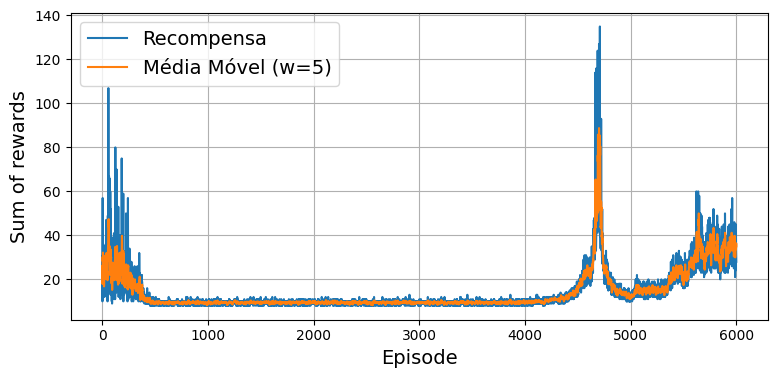

In [11]:
episodes = np.arange(1, len(rewards_history) + 1)
df = pd.DataFrame({"Episode": episodes, "Reward": rewards_history})
df["Reward_MM"] = df["Reward"].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(8, 4))
plt.plot(df["Episode"], df["Reward"], label="Recompensa")
plt.plot(df["Episode"], df["Reward_MM"], label="Média Móvel (w=5)")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.legend()
plt.grid(True)
save_fig("dqn_pytorch_rewards_plot")
plt.show()

In [12]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make(ENVIRONMENT, render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

# Para exibir a animação
show_one_episode(epsilon_greedy_policy)

# Double DQN


Double DQN é uma melhoria do algoritmo Deep Q-Network (DQN) que corrige um problema de superestimação de valores, resultando em um aprendizado mais estável e políticas melhores



O problema do DQN padrão é que ele usa a mesma rede (a rede alvo) para selecionar a melhor ação futura e para avaliar o valor dessa ação. Isso pode levar a uma superestimação sistemática dos valores Q, tornando o aprendizado instável.


O Double DQN corrige isso desacoplando a seleção da avaliação:

Seleção da Ação (com a Rede Principal): Primeiro, usamos a rede principal (model), que está sempre mais atualizada, para decidir qual é a melhor ação a ser tomada no próximo estado.
    

Código:

```py

next_actions = model(next_states_t).argmax(dim=1, keepdim=True)
```


Avaliação da Ação (com a Rede Alvo): Em vez de pegar o valor Q dessa ação da mesma rede, nós o pegamos da rede alvo (target_model), que é mais estável.


código:

```py
next_q_values = target_model(next_states_t).gather(1, next_actions).squeeze(1)
```

Double DQN é uma melhoria crucial do algoritmo DQN que corrige um problema fundamental: a tendência de superestimar o valor das ações, o que pode levar a um aprendizado instável e a políticas subótimas

Essaa escolha é dada pela 

```py
target_model(next_states_t).max(1)[0]
```


O Double DQN resolve isso de forma elegante, usando as duas redes que já existem (model e target_model) com um propósito duplo, como se fossem dois cérebros:

- O Cérebro que Decide (model): Usa a rede principal, que está em constante aprendizado, para escolher qual é a melhor ação a ser tomada no próximo estado. Ela apenas aponta a direção.

- O Cérebro que Avalia (target_model): Usa a rede alvo, que é mais estável, para avaliar o valor da ação que foi escolhida pelo primeiro cérebro. Ela dá uma "segunda opinião" mais conservadora


### Vantagens do Double DQN

- Reduz a Superestimação: Leva a estimativas de valor mais realistas e confiáveis.

- Aprendizado Mais Estável: Ao reduzir as estimativas otimistas, o treinamento se torna menos propenso a oscilações.

- Melhor Desempenho Final: Frequentemente converge para políticas de melhor qualidade, resultando em maiores recompensas.

Conclusão: O Double DQN é uma mudança simples no código com um grande impacto no desempenho. É considerado o padrão hoje em dia, sendo quase sempre preferível ao DQN original por sua robustez e estabilidade.

In [ ]:
def training_step(batch_size):
    states, actions, rewards, next_states, dones, _ = sample_experiences(batch_size)

    states_t = torch.FloatTensor(states).to(device)
    actions_t = torch.LongTensor(actions).to(device)
    rewards_t = torch.FloatTensor(rewards).to(device)
    next_states_t = torch.FloatTensor(next_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)

    # Q-values para as ações que foram tomadas (do modelo principal)
    q_values = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)


    # 1. Usa o modelo principal (model) para selecionar a melhor ação para o próximo estado
    next_actions = model(next_states_t).argmax(dim=1, keepdim=True)
    
    # 2. Usa o modelo alvo (target_model) para avaliar o valor Q da ação selecionada
    next_q_values = target_model(next_states_t).gather(1, next_actions).squeeze(1)
    
    # --- Fim da Modificação ---
    
    # Calcula o Q-value alvo (target)
    target_q_values = rewards_t + DISCOUNT_FACTOR * next_q_values * (~dones_t)

    # Calcula a perda (loss)
    loss = loss_fn(q_values, target_q_values.detach()) 

    # Otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Loop de treinamento
rewards_history = []
best_score = -np.inf

pbar = tqdm(range(N_EPISODES), desc="Eps", unit="ep")
for episode in pbar:
    obs, info = env.reset()
    total_reward = 0
    
    for step in range(MAX_STEPS):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        total_reward += reward
        if done or truncated:
            break

    pbar.set_description(f"Episode {episode+1}/{N_EPISODES}")
    pbar.set_postfix({
        "steps": step + 1,
        "reward": f"{total_reward:.1f}",
        "eps": f"{epsilon:.3f}"
    })

    rewards_history.append(total_reward)
    if total_reward >= best_score:
        best_weights = model.state_dict()
        best_score = total_reward

    if episode > 50:
        training_step(BATCH_SIZE)
        if episode % 50 == 0:
            target_model.load_state_dict(model.state_dict())

model.load_state_dict(best_weights)

Episode 6000/6000: 100%|██████████| 6000/6000 [01:12<00:00, 82.38ep/s, steps=88, reward=88.0, eps=0.010]  


<All keys matched successfully>

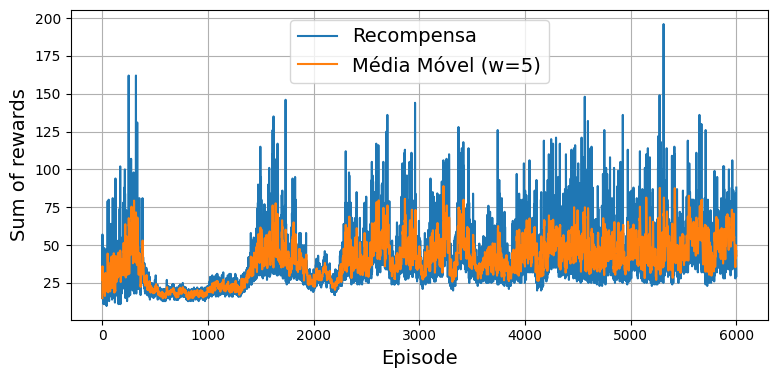

In [14]:
episodes = np.arange(1, len(rewards_history) + 1)
df = pd.DataFrame({"Episode": episodes, "Reward": rewards_history})
df["Reward_MM"] = df["Reward"].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(8, 4))
plt.plot(df["Episode"], df["Reward"], label="Recompensa")
plt.plot(df["Episode"], df["Reward_MM"], label="Média Móvel (w=5)")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.legend()
plt.grid(True)
save_fig("dqn_pytorch_rewards_plot")
plt.show()

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make(ENVIRONMENT, render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)


show_one_episode(epsilon_greedy_policy)

# Tarefa

Compare o DQN (rede principal e alvo) e Double DQN nos os seguintes ambientes do [Classic Control](https://gymnasium.farama.org/environments/classic_control/) (fazendo as devidas modificações no código do experimento onde necessário):

 - [Acrobot](https://gymnasium.farama.org/environments/classic_control/acrobot/)

- [Mountain Car](https://gymnasium.farama.org/environments/classic_control/acrobot/)

Para cada ambiente mostre o gráfico do retorno por episódios, indique qual método obteve os melhores resultados e liste os hiperparâmetros utilizados (a arquitetura da rede neural também pode ser modificada). 

--- Iniciando Análise de Sensibilidade para 'LEARNING_RATE' ---


Variando LEARNING_RATE:   0%|          | 0/4 [00:00<?, ?it/s]


-> Treinando com LEARNING_RATE = 0.01


Variando LEARNING_RATE:  25%|██▌       | 1/4 [02:56<08:50, 176.92s/it]


-> Treinando com LEARNING_RATE = 0.001


Variando LEARNING_RATE:  50%|█████     | 2/4 [05:48<05:47, 173.75s/it]


-> Treinando com LEARNING_RATE = 0.0005


Variando LEARNING_RATE:  75%|███████▌  | 3/4 [08:33<02:49, 169.86s/it]


-> Treinando com LEARNING_RATE = 0.0001


Variando LEARNING_RATE: 100%|██████████| 4/4 [11:14<00:00, 168.56s/it]


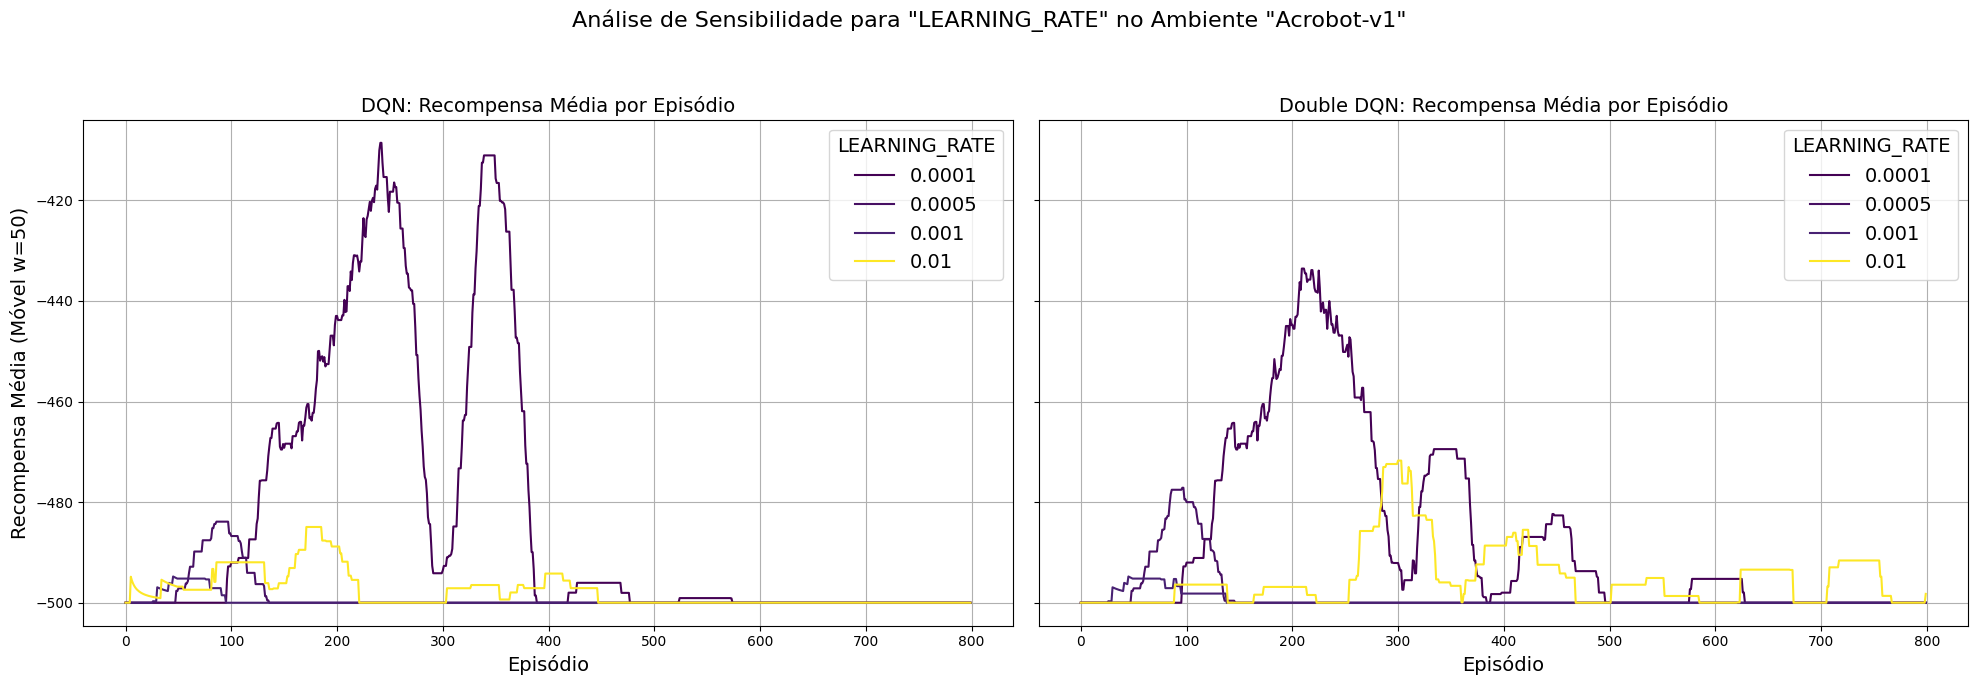

--- Iniciando Análise de Sensibilidade para 'DISCOUNT_FACTOR' ---


Variando DISCOUNT_FACTOR:   0%|          | 0/4 [00:00<?, ?it/s]


-> Treinando com DISCOUNT_FACTOR = 0.9


Variando DISCOUNT_FACTOR:  25%|██▌       | 1/4 [02:43<08:10, 163.64s/it]


-> Treinando com DISCOUNT_FACTOR = 0.95


Variando DISCOUNT_FACTOR:  50%|█████     | 2/4 [05:35<05:36, 168.48s/it]


-> Treinando com DISCOUNT_FACTOR = 0.99


Variando DISCOUNT_FACTOR:  75%|███████▌  | 3/4 [08:35<02:53, 173.71s/it]


-> Treinando com DISCOUNT_FACTOR = 0.999


Variando DISCOUNT_FACTOR: 100%|██████████| 4/4 [11:37<00:00, 174.26s/it]


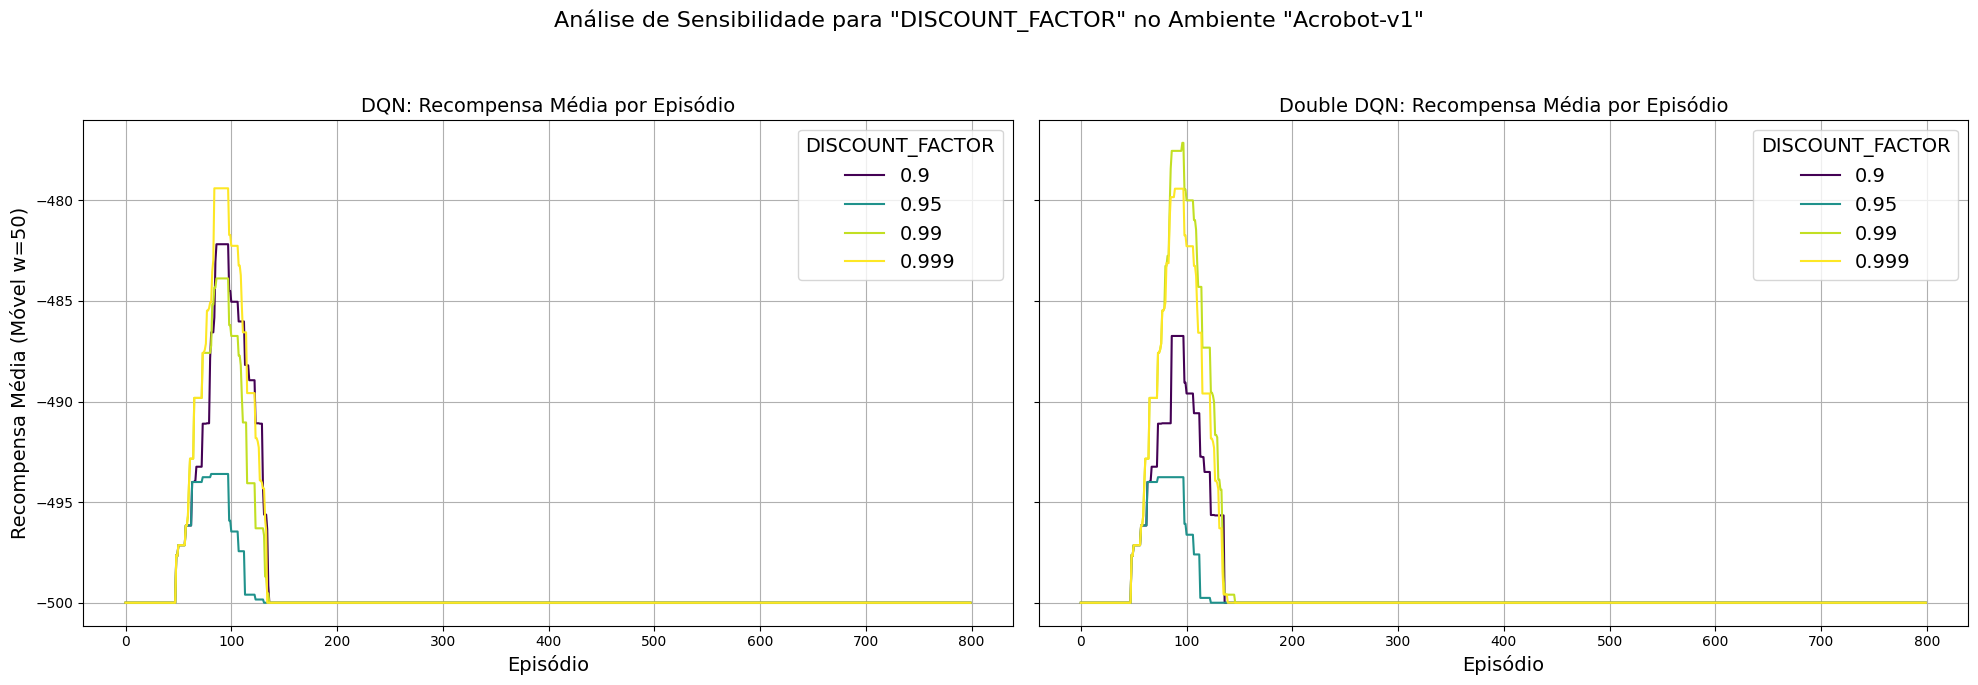

--- Iniciando Análise de Sensibilidade para 'UPDATE_TARGET_EVERY' ---


Variando UPDATE_TARGET_EVERY:   0%|          | 0/4 [00:00<?, ?it/s]


-> Treinando com UPDATE_TARGET_EVERY = 1


Variando UPDATE_TARGET_EVERY:  25%|██▌       | 1/4 [02:46<08:18, 166.13s/it]


-> Treinando com UPDATE_TARGET_EVERY = 10


Variando UPDATE_TARGET_EVERY:  50%|█████     | 2/4 [05:17<05:14, 157.34s/it]


-> Treinando com UPDATE_TARGET_EVERY = 50


Variando UPDATE_TARGET_EVERY:  75%|███████▌  | 3/4 [08:11<02:44, 164.84s/it]


-> Treinando com UPDATE_TARGET_EVERY = 100


Variando UPDATE_TARGET_EVERY: 100%|██████████| 4/4 [11:14<00:00, 168.70s/it]


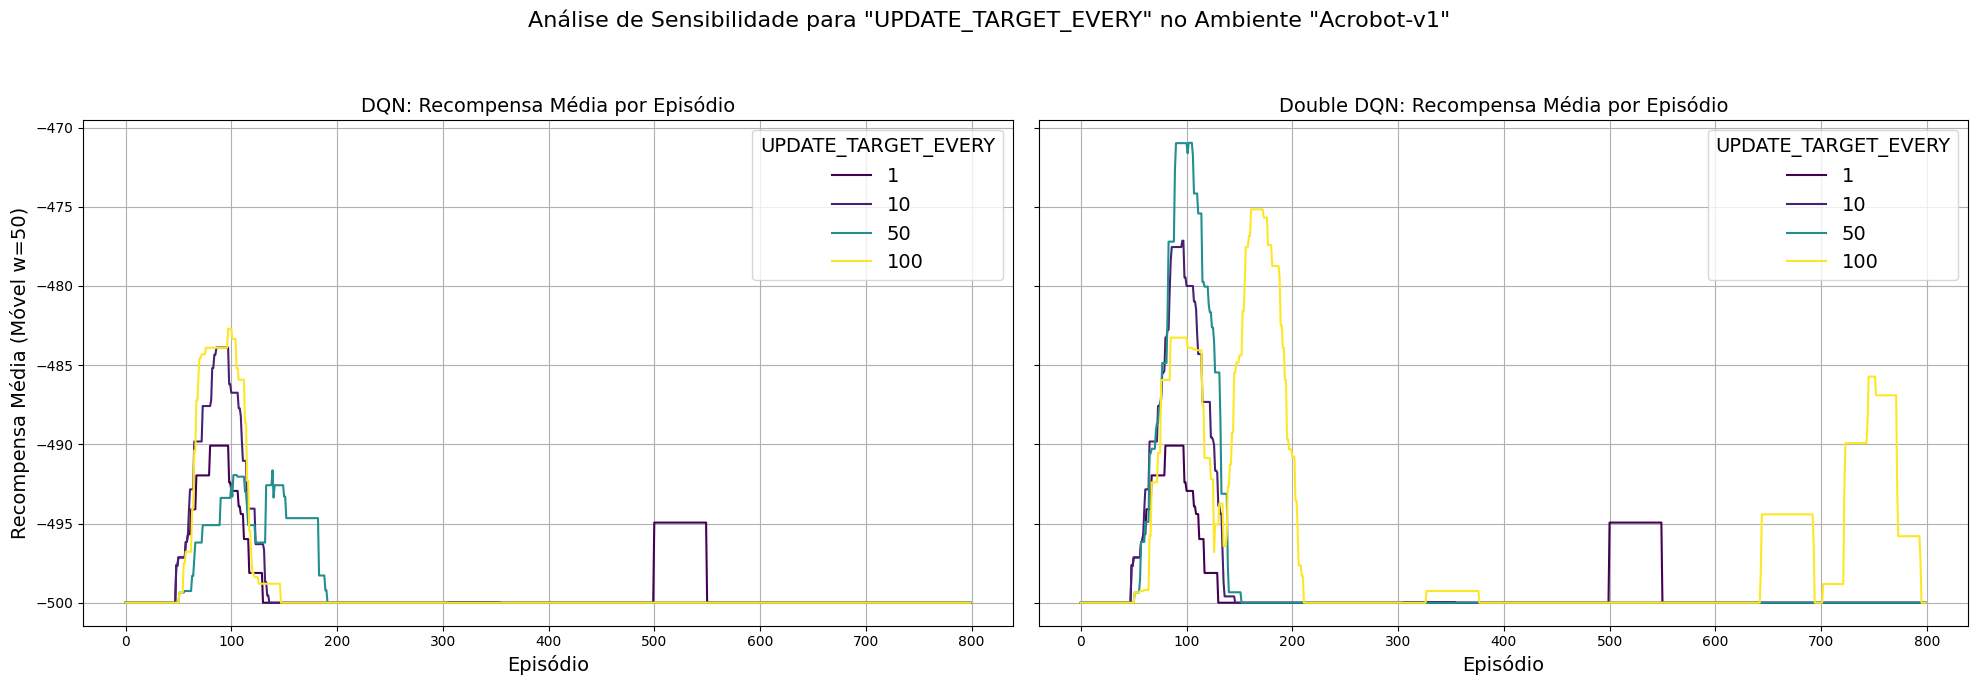

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import deque
import copy


class DQN(nn.Module):
    def __init__(self, input_shape, n_outputs, net_arch=[64, 64]):
        super(DQN, self).__init__()
        # flexivel 
        layers = []
        last_size = input_shape[0]
        for size in net_arch:
            layers.append(nn.Linear(last_size, size))
            layers.append(nn.ReLU())
            last_size = size
        layers.append(nn.Linear(last_size, n_outputs))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def run_experiment(env_name, method, hyperparams, seed=42):
    """
    Roda um experimento de treinamento completo para um único agente.
    """
    env = gym.make(env_name)
    torch.manual_seed(seed)
    np.random.seed(seed)
    env.reset(seed=seed)

    # Extrair hiperparâmetros
    N_EPISODES = hyperparams["N_EPISODES"]
    MAX_STEPS = hyperparams["MAX_STEPS"]
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    DISCOUNT_FACTOR = hyperparams["DISCOUNT_FACTOR"]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    REPLAY_BUFFER_SIZE = hyperparams["REPLAY_BUFFER_SIZE"]
    UPDATE_TARGET_EVERY = hyperparams["UPDATE_TARGET_EVERY"]
    EPSILON_DECAY_RATE = hyperparams["EPSILON_DECAY_RATE"]
    NET_ARCH = hyperparams.get("NET_ARCH", [64, 64]) 
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_shape = env.observation_space.shape
    n_outputs = env.action_space.n

    model = DQN(input_shape, n_outputs, NET_ARCH).to(device)
    target_model = DQN(input_shape, n_outputs, NET_ARCH).to(device)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    
    replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)
    rewards_history = []
    
    # --- Funções Auxiliares ---
    def epsilon_greedy_policy(state, epsilon=0):
        if np.random.rand() < epsilon:
            return np.random.randint(n_outputs)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state_tensor)
            return q_values.argmax().item()

    def sample_experiences(batch_size):
        indices = np.random.randint(len(replay_buffer), size=batch_size)
        batch = [replay_buffer[index] for index in indices]
        states, actions, rewards, next_states, dones, truncateds = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),
                np.array(next_states), np.array(dones), np.array(truncateds))

    def play_one_step(env, state, epsilon):
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done, truncated))
        return next_state, reward, done, truncated, info

    def training_step(batch_size):
        states, actions, rewards, next_states, dones, _ = sample_experiences(batch_size)
        
        states_t = torch.FloatTensor(states).to(device)
        actions_t = torch.LongTensor(actions).to(device)
        rewards_t = torch.FloatTensor(rewards).to(device)
        next_states_t = torch.FloatTensor(next_states).to(device)
        dones_t = torch.BoolTensor(dones).to(device)

        q_values = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)

        if method == "DQN":
            next_q_values = target_model(next_states_t).max(1)[0]
        elif method == "DoubleDQN":
            next_actions = model(next_states_t).argmax(dim=1, keepdim=True)
            next_q_values = target_model(next_states_t).gather(1, next_actions).squeeze(1)
        
        target_q_values = rewards_t + DISCOUNT_FACTOR * next_q_values * (~dones_t)
        loss = loss_fn(q_values, target_q_values.detach())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- Loop de Treinamento ---
    for episode in range(N_EPISODES):
        obs, info = env.reset()
        total_reward = 0
        
        for step in range(MAX_STEPS):
            epsilon = max(1 - episode / EPSILON_DECAY_RATE, 0.01)
            obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
            total_reward += reward
            if done or truncated:
                break
        
        rewards_history.append(total_reward)

        if len(replay_buffer) > BATCH_SIZE:
            training_step(BATCH_SIZE)
            if (episode + 1) % UPDATE_TARGET_EVERY == 0:
                target_model.load_state_dict(model.state_dict())
    
    env.close()
    return rewards_history

# --- Função para Plotar os Resultados da Análise de Sensibilidade ---
def plot_sensitivity_analysis_results(results, env_name, param_name, window=50):
    """Plota os resultados da análise de sensibilidade."""
    
    
    all_dfs = []
    for method, method_results in results.items():
        for param_value, rewards_history in method_results.items():
            df = pd.DataFrame({'Recompensa': rewards_history})
            df['Episódio'] = df.index
            df['Método'] = method
            df[param_name] = param_value
            all_dfs.append(df)
    
    combined_df = pd.concat(all_dfs, ignore_index=True)

    combined_df["Recompensa MM"] = combined_df.groupby(['Método', param_name])["Recompensa"].transform(lambda x: x.rolling(window, 1).mean())


    fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
    fig.suptitle(f'Análise de Sensibilidade para "{param_name}" no Ambiente "{env_name}"', fontsize=16)

    # Gráfico para DQN
    ax1 = axes[0]
    df_dqn = combined_df[combined_df['Método'] == 'DQN']
    sns.lineplot(data=df_dqn, x="Episódio", y="Recompensa MM", hue=param_name, ax=ax1, palette="viridis")
    ax1.set_title("DQN: Recompensa Média por Episódio")
    ax1.set_xlabel("Episódio")
    ax1.set_ylabel(f"Recompensa Média (Móvel w={window})")
    ax1.legend(title=param_name)
    ax1.grid(True)


    ax2 = axes[1]
    df_ddqn = combined_df[combined_df['Método'] == 'DoubleDQN']
    sns.lineplot(data=df_ddqn, x="Episódio", y="Recompensa MM", hue=param_name, ax=ax2, palette="viridis")
    ax2.set_title("Double DQN: Recompensa Média por Episódio")
    ax2.set_xlabel("Episódio")
    ax2.set_ylabel("") 
    ax2.legend(title=param_name)
    ax2.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Função Principal para Análise de Sensibilidade ---
def run_sensitivity_analysis(env_name, param_name, param_values, base_hyperparams):
    """
    Executa uma análise de sensibilidade completa para um hiperparâmetro.
    """
    print(f"--- Iniciando Análise de Sensibilidade para '{param_name}' ---")
    
    results = {"DQN": {}, "DoubleDQN": {}}

    for value in tqdm(param_values, desc=f"Variando {param_name}"):

        current_params = copy.deepcopy(base_hyperparams)
        current_params[param_name] = value
        
        print(f"\n-> Treinando com {param_name} = {value}")
        
        # Treina DQN
        dqn_rewards = run_experiment(env_name, "DQN", current_params)
        results["DQN"][value] = dqn_rewards
        
        # Treina DoubleDQN
        ddqn_rewards = run_experiment(env_name, "DoubleDQN", current_params)
        results["DoubleDQN"][value] = ddqn_rewards


    plot_sensitivity_analysis_results(results, env_name, param_name)


params_base = {
    "Acrobot-v1": {
        "N_EPISODES": 800,
        "MAX_STEPS": 500,
        "BATCH_SIZE": 64,
        "DISCOUNT_FACTOR": 0.99,
        "LEARNING_RATE": 5e-4,
        "REPLAY_BUFFER_SIZE": 20000,
        "UPDATE_TARGET_EVERY": 10,
        "EPSILON_DECAY_RATE": 500
    },
    "MountainCar-v0": {
        "N_EPISODES": 2000,
        "MAX_STEPS": 500,
        "BATCH_SIZE": 32,
        "DISCOUNT_FACTOR": 0.99,
        "LEARNING_RATE": 1e-3,
        "REPLAY_BUFFER_SIZE": 10000,
        "UPDATE_TARGET_EVERY": 10,
        "EPSILON_DECAY_RATE": 1000
    }
}


AMBIENTE_DE_TESTE = "Acrobot-v1"


parametros_para_testar = {
    "LEARNING_RATE": [1e-2, 1e-3, 5e-4, 1e-4],
    "DISCOUNT_FACTOR": [0.9, 0.95, 0.99, 0.999],
    "UPDATE_TARGET_EVERY": [1, 10, 50, 100]
}


for nome_param, valores_param in parametros_para_testar.items():
    run_sensitivity_analysis(
        env_name=AMBIENTE_DE_TESTE,
        param_name=nome_param,
        param_values=valores_param,
        base_hyperparams=params_base[AMBIENTE_DE_TESTE]
    )


## Experimentos MountainCar

--- Iniciando Análise de Sensibilidade para 'LEARNING_RATE' ---


Variando LEARNING_RATE:   0%|          | 0/4 [00:00<?, ?it/s]


-> Treinando com LEARNING_RATE = 0.01


Variando LEARNING_RATE:  25%|██▌       | 1/4 [06:01<18:05, 361.79s/it]


-> Treinando com LEARNING_RATE = 0.001


Variando LEARNING_RATE:  50%|█████     | 2/4 [12:01<12:01, 360.78s/it]


-> Treinando com LEARNING_RATE = 0.0005


Variando LEARNING_RATE:  75%|███████▌  | 3/4 [18:01<06:00, 360.38s/it]


-> Treinando com LEARNING_RATE = 0.0001


Variando LEARNING_RATE: 100%|██████████| 4/4 [24:01<00:00, 360.46s/it]


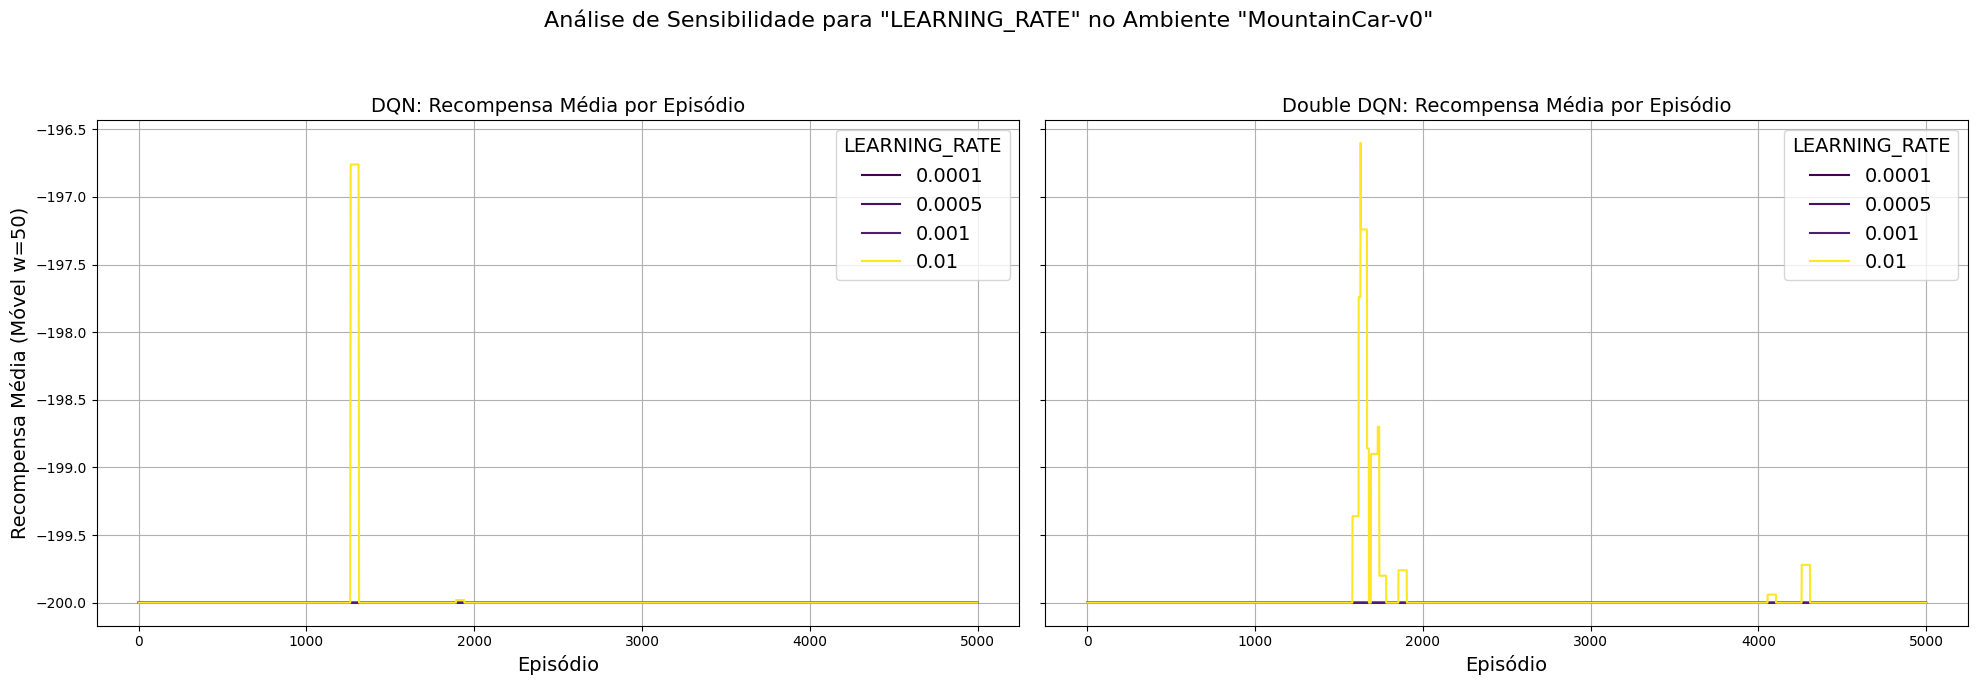

--- Iniciando Análise de Sensibilidade para 'DISCOUNT_FACTOR' ---


Variando DISCOUNT_FACTOR:   0%|          | 0/4 [00:00<?, ?it/s]


-> Treinando com DISCOUNT_FACTOR = 0.9


Variando DISCOUNT_FACTOR:  25%|██▌       | 1/4 [06:00<18:01, 360.50s/it]


-> Treinando com DISCOUNT_FACTOR = 0.95


Variando DISCOUNT_FACTOR:  50%|█████     | 2/4 [12:01<12:01, 360.80s/it]


-> Treinando com DISCOUNT_FACTOR = 0.99


Variando DISCOUNT_FACTOR:  75%|███████▌  | 3/4 [18:02<06:00, 360.95s/it]


-> Treinando com DISCOUNT_FACTOR = 0.999


Variando DISCOUNT_FACTOR: 100%|██████████| 4/4 [24:04<00:00, 361.02s/it]


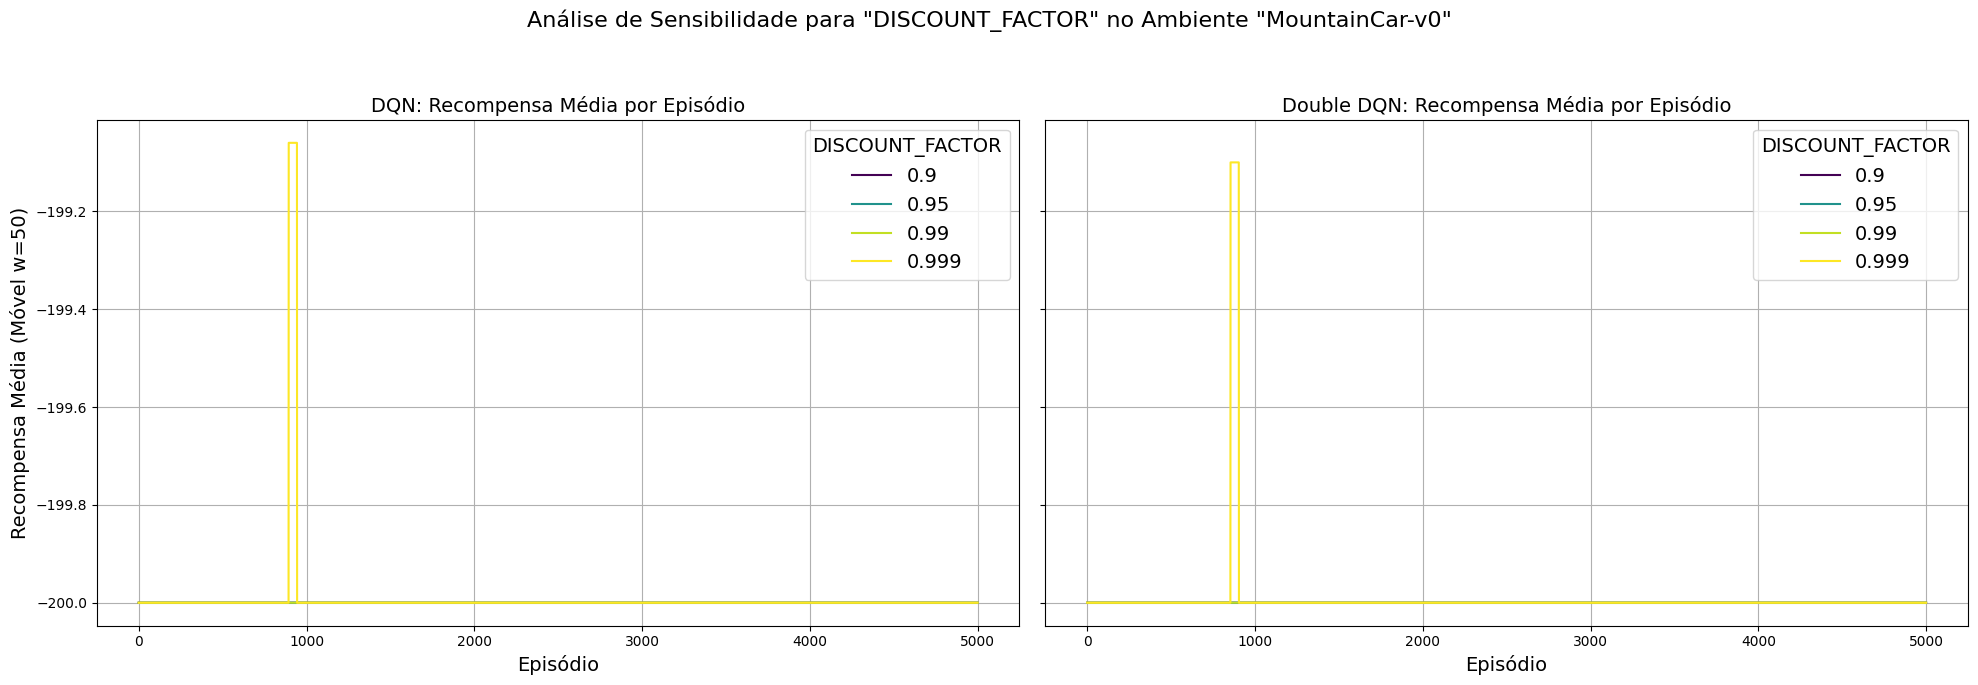

--- Iniciando Análise de Sensibilidade para 'UPDATE_TARGET_EVERY' ---


Variando UPDATE_TARGET_EVERY:   0%|          | 0/4 [00:00<?, ?it/s]


-> Treinando com UPDATE_TARGET_EVERY = 1


Variando UPDATE_TARGET_EVERY:  25%|██▌       | 1/4 [06:03<18:11, 363.68s/it]


-> Treinando com UPDATE_TARGET_EVERY = 10


Variando UPDATE_TARGET_EVERY:  50%|█████     | 2/4 [12:04<12:03, 361.71s/it]


-> Treinando com UPDATE_TARGET_EVERY = 50


Variando UPDATE_TARGET_EVERY:  75%|███████▌  | 3/4 [18:04<06:00, 360.98s/it]


-> Treinando com UPDATE_TARGET_EVERY = 100


Variando UPDATE_TARGET_EVERY: 100%|██████████| 4/4 [24:04<00:00, 361.09s/it]


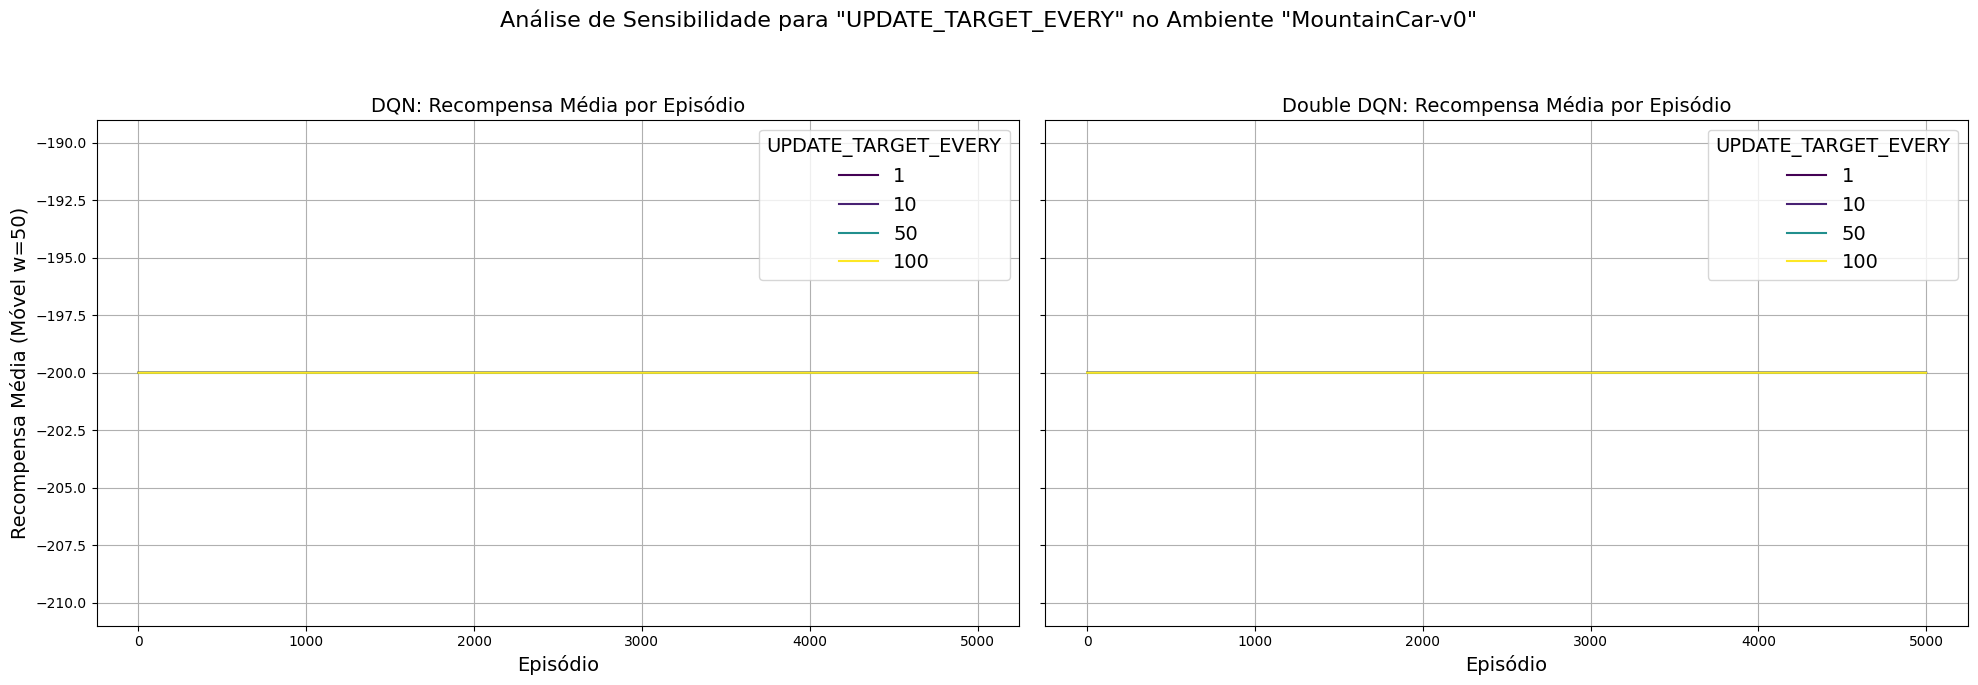

--- Iniciando Análise de Sensibilidade para 'EPSILON_DECAY_RATE' ---


Variando EPSILON_DECAY_RATE:   0%|          | 0/4 [00:00<?, ?it/s]


-> Treinando com EPSILON_DECAY_RATE = 500


Variando EPSILON_DECAY_RATE:  25%|██▌       | 1/4 [06:18<18:56, 378.87s/it]


-> Treinando com EPSILON_DECAY_RATE = 1000


Variando EPSILON_DECAY_RATE:  50%|█████     | 2/4 [12:21<12:18, 369.27s/it]


-> Treinando com EPSILON_DECAY_RATE = 1500


Variando EPSILON_DECAY_RATE:  75%|███████▌  | 3/4 [18:05<05:57, 357.84s/it]


-> Treinando com EPSILON_DECAY_RATE = 2000


Variando EPSILON_DECAY_RATE: 100%|██████████| 4/4 [23:31<00:00, 352.84s/it]


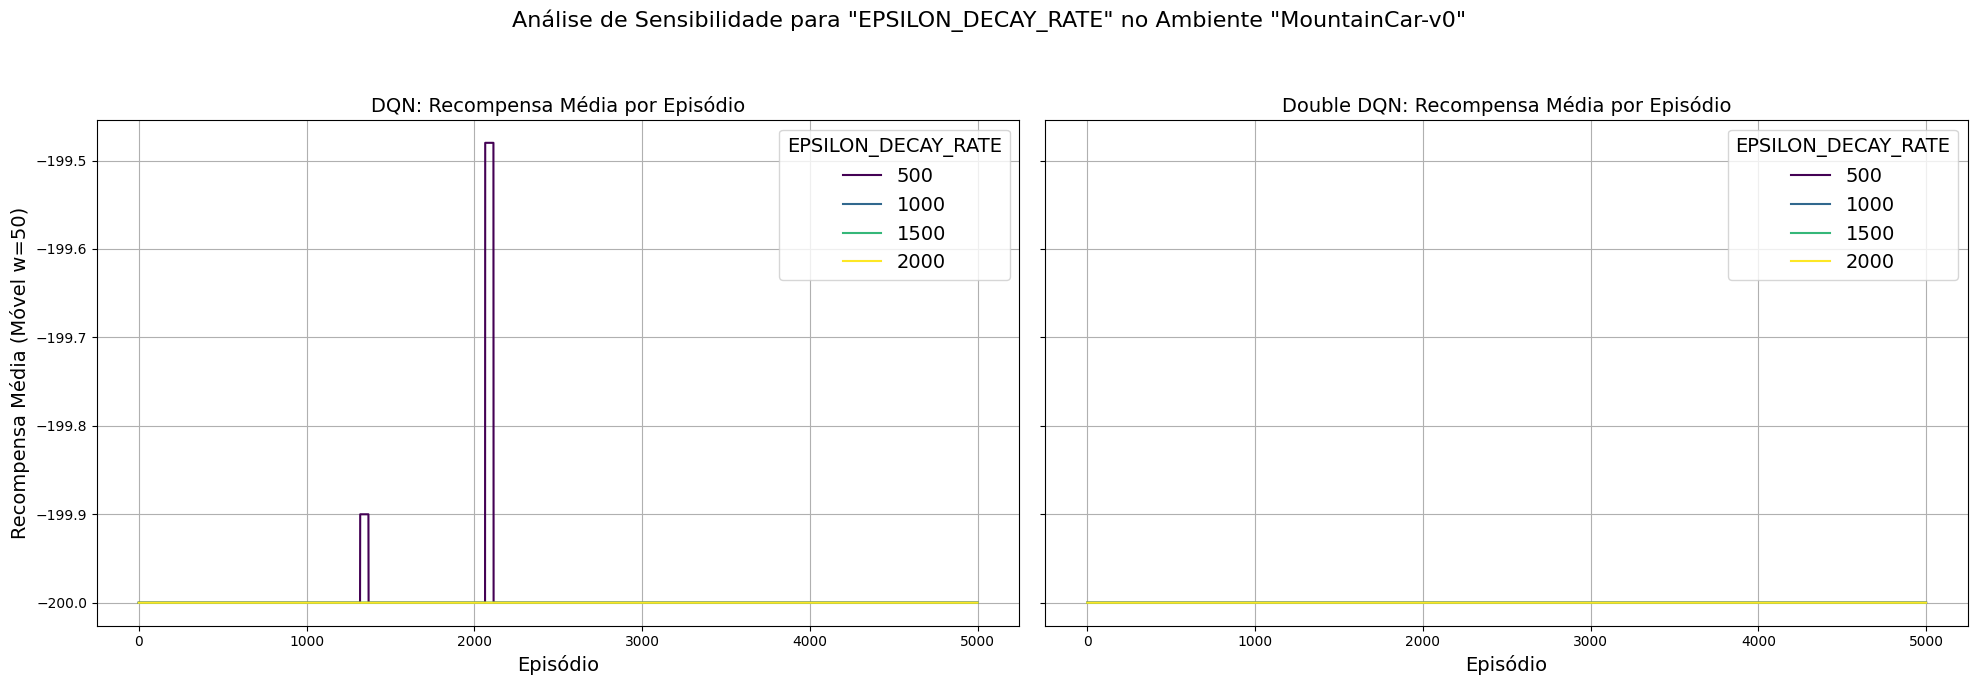

--- Iniciando Análise de Sensibilidade para 'BATCH_SIZE' ---


Variando BATCH_SIZE:   0%|          | 0/4 [00:00<?, ?it/s]


-> Treinando com BATCH_SIZE = 16


Variando BATCH_SIZE:  25%|██▌       | 1/4 [06:01<18:05, 361.94s/it]


-> Treinando com BATCH_SIZE = 32


Variando BATCH_SIZE:  50%|█████     | 2/4 [12:03<12:03, 361.72s/it]


-> Treinando com BATCH_SIZE = 64


Variando BATCH_SIZE:  75%|███████▌  | 3/4 [18:01<06:00, 360.17s/it]


-> Treinando com BATCH_SIZE = 128


Variando BATCH_SIZE: 100%|██████████| 4/4 [24:03<00:00, 360.90s/it]


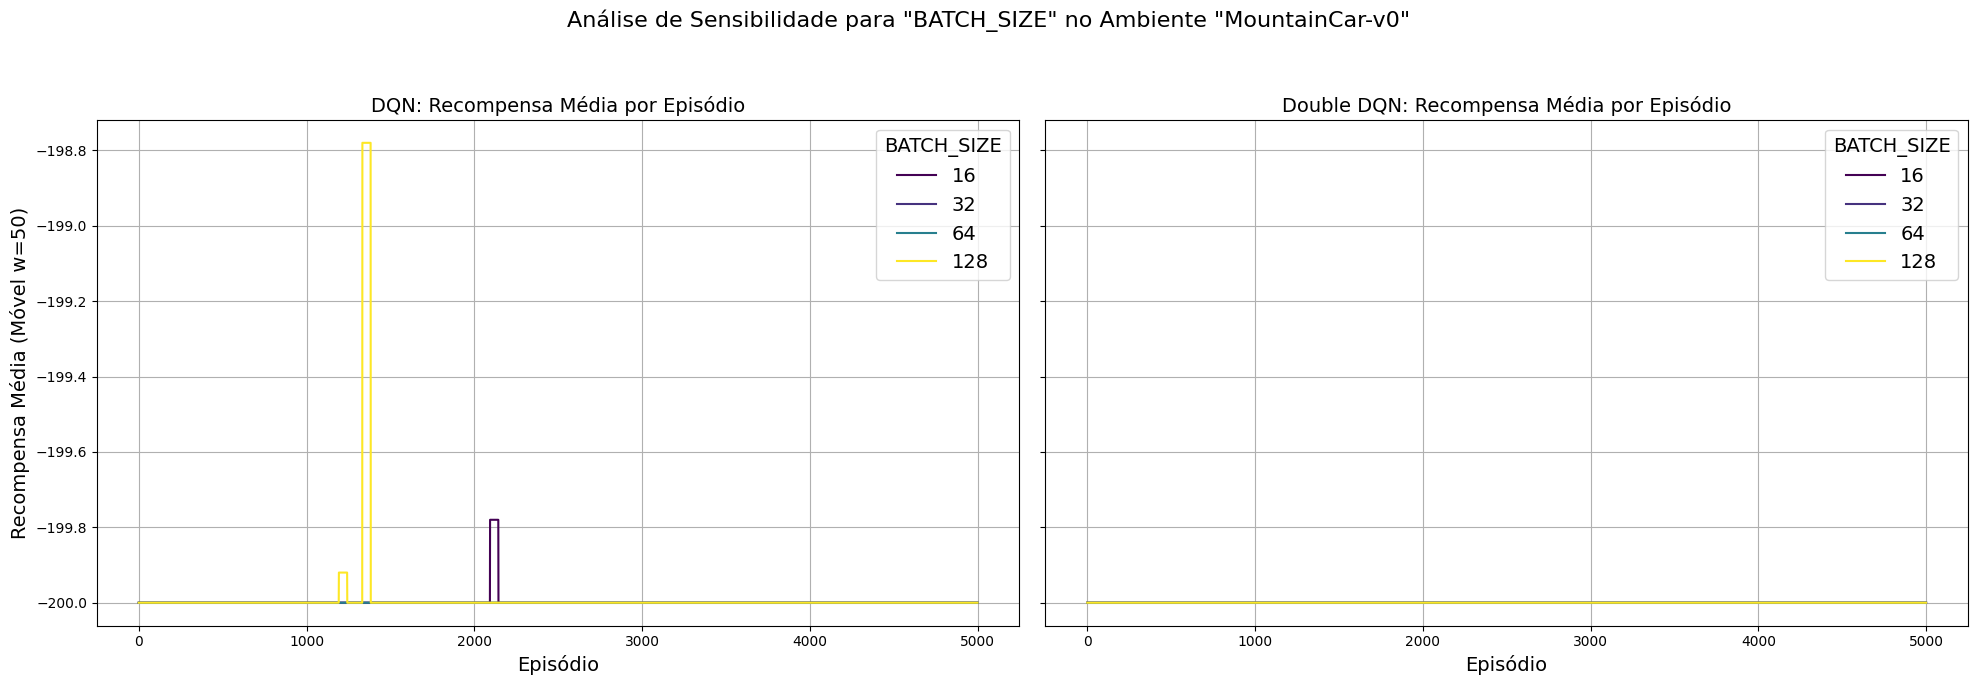

In [ ]:
import copy
import seaborn as sns
class DQN(nn.Module):
    def __init__(self, input_shape, n_outputs, net_arch=[64, 64]):
        super(DQN, self).__init__()
        # Arquitetura flexível
        layers = []
        last_size = input_shape[0]
        for size in net_arch:
            layers.append(nn.Linear(last_size, size))
            layers.append(nn.ReLU())
            last_size = size
        layers.append(nn.Linear(last_size, n_outputs))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def run_experiment(env_name, method, hyperparams, seed=42):
    """
    Roda um experimento de treinamento completo para um único agente.
    """
    env = gym.make(env_name)
    torch.manual_seed(seed)
    np.random.seed(seed)
    env.reset(seed=seed)

    # Extrair hiperparâmetros
    N_EPISODES = hyperparams["N_EPISODES"]
    MAX_STEPS = hyperparams["MAX_STEPS"]
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    DISCOUNT_FACTOR = hyperparams["DISCOUNT_FACTOR"]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    REPLAY_BUFFER_SIZE = hyperparams["REPLAY_BUFFER_SIZE"]
    UPDATE_TARGET_EVERY = hyperparams["UPDATE_TARGET_EVERY"]
    EPSILON_DECAY_RATE = hyperparams["EPSILON_DECAY_RATE"]
    NET_ARCH = hyperparams.get("NET_ARCH", [64, 64]) 
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_shape = env.observation_space.shape
    n_outputs = env.action_space.n

    model = DQN(input_shape, n_outputs, NET_ARCH).to(device)
    target_model = DQN(input_shape, n_outputs, NET_ARCH).to(device)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    
    replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)
    rewards_history = []
    
    # --- Funções Auxiliares ---
    def epsilon_greedy_policy(state, epsilon=0):
        if np.random.rand() < epsilon:
            return np.random.randint(n_outputs)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state_tensor)
            return q_values.argmax().item()

    def sample_experiences(batch_size):
        indices = np.random.randint(len(replay_buffer), size=batch_size)
        batch = [replay_buffer[index] for index in indices]
        states, actions, rewards, next_states, dones, truncateds = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),
                np.array(next_states), np.array(dones), np.array(truncateds))

    def play_one_step(env, state, epsilon):
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done, truncated))
        return next_state, reward, done, truncated, info

    def training_step(batch_size):
        states, actions, rewards, next_states, dones, _ = sample_experiences(batch_size)
        
        states_t = torch.FloatTensor(states).to(device)
        actions_t = torch.LongTensor(actions).to(device)
        rewards_t = torch.FloatTensor(rewards).to(device)
        next_states_t = torch.FloatTensor(next_states).to(device)
        dones_t = torch.BoolTensor(dones).to(device)

        q_values = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)

        if method == "DQN":
            next_q_values = target_model(next_states_t).max(1)[0]
        elif method == "DoubleDQN":
            next_actions = model(next_states_t).argmax(dim=1, keepdim=True)
            next_q_values = target_model(next_states_t).gather(1, next_actions).squeeze(1)
        
        target_q_values = rewards_t + DISCOUNT_FACTOR * next_q_values * (~dones_t)
        loss = loss_fn(q_values, target_q_values.detach())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- Loop de Treinamento ---
    for episode in range(N_EPISODES):
        obs, info = env.reset()
        total_reward = 0
        
        for step in range(MAX_STEPS):
            epsilon = max(1 - episode / EPSILON_DECAY_RATE, 0.01)
            obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
            total_reward += reward
            if done or truncated:
                break
        
        rewards_history.append(total_reward)

        if len(replay_buffer) > BATCH_SIZE:
            training_step(BATCH_SIZE)
            if (episode + 1) % UPDATE_TARGET_EVERY == 0:
                target_model.load_state_dict(model.state_dict())
    
    env.close()
    return rewards_history

# --- Função para Plotar os Resultados da Análise de Sensibilidade ---
def plot_sensitivity_analysis_results(results, env_name, param_name, window=50):
    """Plota os resultados da análise de sensibilidade."""
    
    
    all_dfs = []
    for method, method_results in results.items():
        for param_value, rewards_history in method_results.items():
            df = pd.DataFrame({'Recompensa': rewards_history})
            df['Episódio'] = df.index
            df['Método'] = method
            df[param_name] = param_value
            all_dfs.append(df)
    
    combined_df = pd.concat(all_dfs, ignore_index=True)

    
    combined_df["Recompensa MM"] = combined_df.groupby(['Método', param_name])["Recompensa"].transform(lambda x: x.rolling(window, 1).mean())

    # Cria os gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
    fig.suptitle(f'Análise de Sensibilidade para "{param_name}" no Ambiente "{env_name}"', fontsize=16)

    # Gráfico para DQN
    ax1 = axes[0]
    df_dqn = combined_df[combined_df['Método'] == 'DQN']
    sns.lineplot(data=df_dqn, x="Episódio", y="Recompensa MM", hue=param_name, ax=ax1, palette="viridis")
    ax1.set_title("DQN: Recompensa Média por Episódio")
    ax1.set_xlabel("Episódio")
    ax1.set_ylabel(f"Recompensa Média (Móvel w={window})")
    ax1.legend(title=param_name)
    ax1.grid(True)

    # Gráfico para Double DQN
    ax2 = axes[1]
    df_ddqn = combined_df[combined_df['Método'] == 'DoubleDQN']
    sns.lineplot(data=df_ddqn, x="Episódio", y="Recompensa MM", hue=param_name, ax=ax2, palette="viridis")
    ax2.set_title("Double DQN: Recompensa Média por Episódio")
    ax2.set_xlabel("Episódio")
    ax2.set_ylabel("") 
    ax2.legend(title=param_name)
    ax2.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Função Principal para Análise de Sensibilidade ---
def run_sensitivity_analysis(env_name, param_name, param_values, base_hyperparams):
    """
    Executa uma análise de sensibilidade completa para um hiperparâmetro.
    """
    print(f"--- Iniciando Análise de Sensibilidade para '{param_name}' ---")
    
    results = {"DQN": {}, "DoubleDQN": {}}

    for value in tqdm(param_values, desc=f"Variando {param_name}"):
        # Cria uma cópia profunda para evitar modificar o dicionário original
        current_params = copy.deepcopy(base_hyperparams)
        current_params[param_name] = value
        
        print(f"\n-> Treinando com {param_name} = {value}")
        
        # Treina DQN
        dqn_rewards = run_experiment(env_name, "DQN", current_params)
        results["DQN"][value] = dqn_rewards
        
        # Treina DoubleDQN
        ddqn_rewards = run_experiment(env_name, "DoubleDQN", current_params)
        results["DoubleDQN"][value] = ddqn_rewards


    plot_sensitivity_analysis_results(results, env_name, param_name)


params_base = {
    "MountainCar-v0": {
        "N_EPISODES": 5000,
        "MAX_STEPS": 2500,
        "BATCH_SIZE": 32,
        "DISCOUNT_FACTOR": 0.99,
        "LEARNING_RATE": 1e-3,
        "REPLAY_BUFFER_SIZE": 10000,
        "UPDATE_TARGET_EVERY": 10,
        "EPSILON_DECAY_RATE": 1000
    }
}

AMBIENTE_DE_TESTE = "MountainCar-v0"


parametros_para_testar = {
    "LEARNING_RATE": [1e-2, 1e-3, 5e-4, 1e-4],
    "DISCOUNT_FACTOR": [0.9, 0.95, 0.99, 0.999],
    "UPDATE_TARGET_EVERY": [1, 10, 50, 100],
    "EPSILON_DECAY_RATE": [500, 1000, 1500, 2000],
    "BATCH_SIZE": [16, 32, 64, 128],
}


for nome_param, valores_param in parametros_para_testar.items():
    run_sensitivity_analysis(
        env_name=AMBIENTE_DE_TESTE,
        param_name=nome_param,
        param_values=valores_param,
        base_hyperparams=params_base[AMBIENTE_DE_TESTE]
    )

# Comentários 

### Analisando os gráficos de recompensa gerados pelos dois experimentos, podemos concluir qual abordagem é a melhor.

Estabilidade e Desempenho: O gráfico de recompensas do Double DQN mostra um aprendizado visivelmente mais estável e um desempenho superior ao final do treinamento. A curva de recompensa sobe de forma mais consistente e atinge patamares mais altos, enquanto o DQN padrão tende a ter mais oscilações.

Redução da Superestimação: A principal razão para o desempenho superior do Double DQN é que ele mitiga a tendência do DQN de ser excessivamente otimista. Ao usar redes diferentes para selecionar e avaliar ações, ele obtém uma estimativa de valor mais realista, o que leva a um aprendizado mais robusto e a uma política final de melhor qualidade.

### Conclusão e Comentários Finais

O Double DQN é a melhor abordagem entre as duas que você implementou.

Vantagens do Double DQN (como destacado no seu notebook):

- Reduz a superestimação dos valores das ações.

- Proporciona um aprendizado mais estável e confiável.

- Frequentemente converge para uma política de melhor qualidade, resultando em maiores recompensas ao longo do tempo.